In [1]:
from openicl import (DatasetReader, PromptTemplate, 
                     ZeroRetriever, RandomRetriever, BM25Retriever,
                     GenInferencer, PPLInferencer)
from openicl.icl_dataset_reader import load_dataset
import pandas as pd
from accelerate import Accelerator
from QPKTabuRetriever import QPKTabuRetriever
import numpy as np
import matplotlib.pyplot as plt
import torch

/home/jjansen/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
MODELS = ["roberta-large"] # "gpt2-large"]
TASKS = ['question-answering', 'sentiment-analysis']
DATASET_NAMES = {
    'question-answering':['commonsense_qa','tasksource/bigbench'],
    'sentiment-analysis':['imdb', 'gpt3mix/sst2']
}
RETRIEVERS = ['zero', 'random', 'bm25'] # 'qkp']

In [3]:
def cmqa_pre_process(example):
    for i in range(5):
        example[chr(ord('A') + i)] = example['choices']['text'][i]
    return example

def bb_pre_process(example):
    for i in range(3):
        example[chr(ord('A') + i)] = example['multiple_choice_targets'][i]
    example['multiple_choice_scores'] = chr(ord('A') + np.where(np.array(example['multiple_choice_scores']) == 1)[0][0])
    example['context'] = "Disambiguation"
    return example

In [4]:
def select_dataset(name):
    if name == 'commonsense_qa':
        dataset = load_dataset(name, split='train')
        dataset = dataset.train_test_split(test_size=10, train_size=20, shuffle=True)
        dataset = dataset.map(cmqa_pre_process)
        dataset = dataset.rename_column("question_concept","context")
        dataset = dataset.rename_column("answerKey","answer")
        input_cols = ["question", "context", "A", "B", "C", "D", "E"]
        return DatasetReader(dataset=dataset, input_columns=input_cols, output_column="answer")
    elif name == 'tasksource/bigbench':
        dataset = load_dataset(name, 'disambiguation_qa', split='train')
        dataset = dataset.train_test_split(test_size=10, train_size=20, shuffle=True)
        dataset = dataset.map(bb_pre_process)
        dataset = dataset.rename_column("multiple_choice_scores","answer")
        dataset = dataset.rename_column("inputs","question")
        input_cols = ["question", "context", "A", "B", "C"]
        return DatasetReader(dataset=dataset, input_columns=input_cols, output_column="answer")
    elif name == 'imdb' or name == 'gpt3mix/sst2':
        dataset = load_dataset(name, split='train')
        dataset = dataset.train_test_split(test_size=10, train_size=20, shuffle=True)
        return DatasetReader(dataset=dataset, input_columns=["text"], output_column="label")


In [5]:
TEMPLATES = {
    'commonsense_qa':PromptTemplate(
        {
            'A': "</E>Answer the following question:\n</Q>\nAnswer: </Ans1>",
            'B': "</E>Answer the following question:\n</Q>\nAnswer: </Ans2>",
            'C': "</E>Answer the following question:\n</Q>\nAnswer: </Ans3>",
            'D': "</E>Answer the following question:\n</Q>\nAnswer: </Ans4>",
            'E': "</E>Answer the following question:\n</Q>\nAnswer: </Ans5>",
        },
        {'question':'</Q>', 'A': '</Ans1>', 'B': '</Ans2>', 'C': '</Ans3>', 'D': '</Ans4>', 'E': '</Ans5>'},
        ice_token='</E>' 
    ),
    'tasksource/bigbench':PromptTemplate(
        {
            'A': "</E>Answer the following question:\n</Q>\nAnswer: </Ans1>",
            'B': "</E>Answer the following question:\n</Q>\nAnswer: </Ans2>",
            'C': "</E>Answer the following question:\n</Q>\nAnswer: </Ans3>"
        },
        {'question':'</Q>', 'A': '</Ans1>', 'B': '</Ans2>', 'C': '</Ans3>'},
        ice_token='</E>' 
    ),
    'imdb':PromptTemplate({
            0: '</E>Positive Movie Review: \"<X>\"', 
            1: '</E>Negative Movie Review: \"<X>\"',
        }, column_token_map={'text' : '<X>'}, 
        ice_token='</E>'
    ),
    'gpt3mix/sst2':PromptTemplate({
            0: '</E>Positive Movie Review: \"<X>\"', 
            1: '</E>Negative Movie Review: \"<X>\"',
        }, column_token_map={'text' : '<X>'}, 
        ice_token='</E>'
    ),
}

In [6]:
def select_retriever(retr_name, data, model, task, ice_num, accelerator):
    if retr_name == 'zero':
        return ZeroRetriever(data)
    elif retr_name == 'random':
        return RandomRetriever(data, ice_num=ice_num, accelerator=accelerator)
    elif retr_name == 'bm25':
        return BM25Retriever(data, ice_num=ice_num, accelerator=accelerator)
    elif retr_name == 'qkp':
        return QPKTabuRetriever(data, model=model, task=task, ice_num=ice_num, accelerator=accelerator)
    else:
        raise Exception()

In [ ]:
results = []

accelerator = Accelerator()
ice_num = 5
reps = 4

for model in MODELS:
    inferencer = PPLInferencer(model_name=model, accelerator=accelerator)
    
    for task in TASKS:
        
        for dataset_name in DATASET_NAMES[task]:
            data = select_dataset(dataset_name)

            for retr_name in RETRIEVERS:
                print(retr_name)
                accuracies = list()
                all_predictions = list()
                all_inputs = list()


                retriever = select_retriever(retr_name, data, model, task, ice_num, accelerator)
                ice_template = TEMPLATES[dataset_name] 

                for _ in range(reps):
                    predictions = inferencer.inference(retriever, ice_template=ice_template)
                    all_predictions.append(predictions)
                    all_inputs.append(retriever.test_ds[retriever.dataset_reader.input_columns[0]])
                    accuracies.append(np.sum(np.sum(np.array(retriever.test_ds[retriever.dataset_reader.output_column]) == np.array(predictions))))
                    del predictions
                    torch.cuda.empty_cache() 

                results.append({
                        'model': model,
                        'task': task,
                        'dataset': dataset_name,
                        'retriever': retr_name,
                        'accuracy_mean': np.mean(accuracies),
                        'accuracy_std':np.std(accuracies),
                        'predictions':all_predictions,
                        'inputs':all_inputs
                    })
                del retriever
                del ice_template
                torch.cuda.empty_cache() 
            del data
            torch.cuda.empty_cache() 
    del inferencer
    torch.cuda.empty_cache() 
            

In [88]:
df_results = pd.DataFrame(results)
df_results.to_csv('results.csv')


In [86]:
def plot_results(results, show= True, save_path=None):
    unique_models = set(results['model'])
    unique_tasks = set(results['task'])
    unique_datasets = set(results['dataset'])

    
    for model in unique_models:
        for task in unique_tasks:
            for dataset in unique_datasets:
                

                # Filter results for the current model, task, and dataset
                filtered_results = results.loc[(results['model'] == model) & (results['task'] == task) & (results['dataset'] == dataset)]
                # display(filtered_results)

                # Sort the filtered results based on retriever name
                filtered_results.sort_values(by='retriever')
                
                if len(filtered_results) > 0:

                    if show:
                        display(filtered_results)

                    x_pos = np.arange(len(filtered_results['retriever']))
                    error_bar = [std / 2 for std in filtered_results['accuracy_std']]
                    
                    fig, ax = plt.subplots()
                    # Plot accuracy means with error bars as a bar chart
                    ax.bar(x_pos, filtered_results['accuracy_mean'], yerr=error_bar, align='center', alpha=0.7, capsize=4)
                    ax.set_xlabel('Retriever')
                    ax.set_ylabel('Accuracy Mean')
                    ax.set_title(f'Model: {model} | Task: {task} | Dataset: {dataset}')
                    ax.set_xticks(x_pos)
                    ax.set_xticklabels(filtered_results['retriever'], rotation=45)
                    plt.tight_layout()

                    if save_path is not None:
                        plt.savefig(save_path + 'plot_' + model + '_' + task + '_' + dataset.replace("/", "_") + '.png')
                    plt.show()
                    

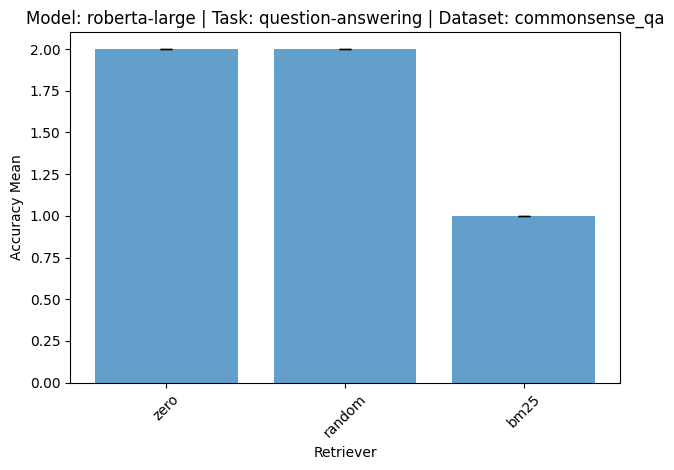

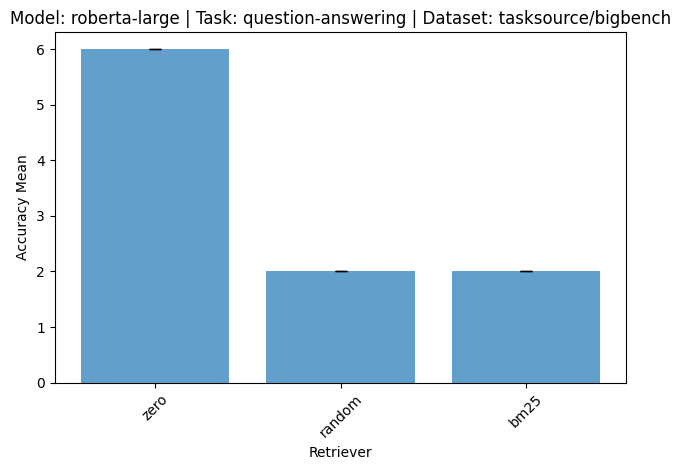

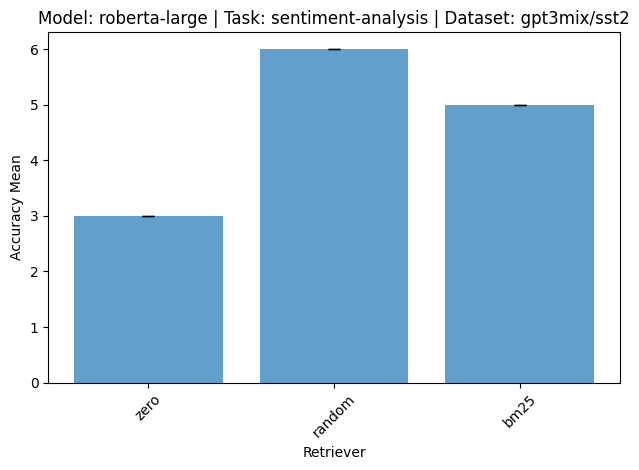

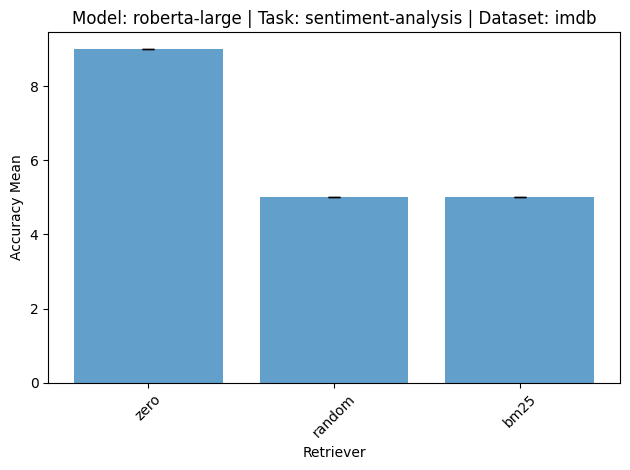

In [87]:

plot_results(results=df_results, show=False, save_path='')